# Digit recognizer

## Part 1 - Create our model & upload to Azure

### We start by importing our data from the MNIST library and set them in a folder

In [1]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7fbff0528c18>)

### Then we create a workspace on Azure

##### We will use this workspace to upload files and run our experiments later

In [3]:
#### No need to run this if you already have a workspace created!!! Skip this & next cells!!!

from azureml.core import Workspace,Experiment,Run

from my_config import key

ws = Workspace.create(
            name='AMLSWorkspace3', #name of the workspace
            subscription_id=key, #password from microsoft (stored in a file called my_config)
            resource_group='rgAMLSLearnworkspace', #
            create_resource_group=False,
            location='eastus2')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FBMAGLF9C to authenticate.
Interactive authentication successfully completed.


WorkspaceException: WorkspaceException:
	Message: Workspace with name 'AMLSWorkspace3' already exists under resource group with name 'rgAMLSLearnworkspace'.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Workspace with name 'AMLSWorkspace3' already exists under resource group with name 'rgAMLSLearnworkspace'."
    }
}

In [ ]:
### Write our ws config to a json, so we can call it easily later
ws.write_config(path="./file-path", file_name="ws_config.json")

In [ ]:
### This calls the config from json
ws = Workspace.from_config()
ws.get_details()

In [30]:
############ OR, IF YOU HAVE THE DETAILS #######################
from my_config import key
ws = Workspace.get(name="AMLSWorkspace3",
               subscription_id=key,
               resource_group='rgAMLSLearnworkspace')

Then we create a test experiment environment to test our workspace

In [31]:
#from azureml.core import Experiment
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-first-experiment")

#Create a run, to test if our experiment works
run = experiment.start_logging()
run.log("trial",1)
run.complete()

In [32]:
#### Get some more information about the environment

from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [33]:
### Provides the link to the experiment, so you can view details in Azure
print(run.get_portal_url())

https://ml.azure.com/experiments/my-first-experiment/runs/67bd42f0-5fd2-44fe-b435-088a5d2ea005?wsid=/subscriptions/1b280dcf-9e0e-4006-9128-c8375f35f7f6/resourcegroups/rgAMLSLearnworkspace/workspaces/AMLSWorkspace3


#### 1) Azure Machine Learning Compute (AmlCompute) as the compute resource

This portion pretty much creates a computer (Virtual machine) for you to use on Azure:

This Virtual machine (vm) is linked to our workspace & can be easily accessed

Allows you pick the configuration too!

In [34]:
#### import all the necessary libraries

from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Step 1: name the cluster and set the minimal and maximal number of nodes 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 3)

# Step 2: choose environment variables 
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

provisioning_config = AmlCompute.provisioning_configuration(
    vm_size = vm_size, min_nodes = min_nodes, max_nodes = max_nodes)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

print('Compute target created')

Compute target created


### 2) Now that we have our workspace "ws" created, we can send our raw files into it

#### Put simply, we are uploading the raw data to azure, so the computer (vm) we just created can make use of it

In [35]:
#upload data by using get_default_datastore()
ds = ws.get_default_datastore() #obtains the default data folder in our ws

# we then upload the files unto azure ws, and store in a folder called "mnist" (created at the instace the ds.upload function is run)
ds.upload(src_dir='./data', target_path ='mnist', overwrite=True, show_progress=True) 

print('Done')

Uploading an estimated of 4 files
Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files
Done


### Next step is to create our model
#### This is pretty much a python script saved on your local computer

In [36]:
##### creates a directory to save your training Python code:

import os

# create the folder
training_script_folder = './trial_model_mnist'
os.makedirs(training_script_folder, exist_ok=True)

print('Done')

Done


### 3) Now that we have our ws & vm set up, let's prepare our model training script

#### The python file we are creating below, will contain our model, Logistic regression in this case:
1) Defines a function that will unzip the files in our ws folder "mnist" on azure
2) When run, will prompt user to enter the parameters mentioned in above cell (data path & regularization rate)
3) Extract & unzip train & test data from the ws, using fuction above & store in variables
4) Train & test our Logistic Regression model, also logs the results
5) Stores our trained Logistic Regression model in a pickle file that we can use to deploy the model later

##### Notes:  
- This whole cell below will not run until the train.py model is called later
- The first parameter is for finding the data in the cloud or for setting the path to the data.
- The other parameter is the regularization parameter in the algorithm.
- We are storing the python file in the folder created above (on your local computer)
- While the pickle file is in our workspace (Azure

In [37]:
%%writefile $training_script_folder/train.py 

#Notifies jupyter notebook not to run this portion but write it to a file, by providing path
#Creates a python file called train.py from the content of this block. 


# Import all relevant libraries
import argparse
import os
import numpy as np
import glob


from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from sklearn.metrics import accuracy_score
from azureml.core import Run
# from utils import load_data

import gzip
import struct

# 1 load compressed MNIST gz files and return numpy arrays
def zip_to_array (filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# 2 let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--reg-rate', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args() ###args is now made up of "args.data_folder" & "args.reg" which we will use later

# 3 Use zip_to_array function
###Extracts the data from our ws folder & stores it in the specified variobles X_train, X_test, y_train, y_test
###  "mnist" we created earlier & "args.data_folder" is one of the arguments we parse above
data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder) #just to see
# load the X train and test set into numpy arrays
X_train = zip_to_array(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = zip_to_array(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
print(X_train.shape, X_test.shape, sep = '\n') #print variable set dimension

# load the y train and test set into numpy arrays
y_train = zip_to_array(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = zip_to_array(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print( y_train.shape, y_test.shape, sep = '\n') #print the response variable dimension


# 4 The Logistic regression model being called into action
####### Get hold of the current run for model scoring - 
########This is very important, as it can be used to store vital information about your model performance
run = Run.get_context()

#### This line creates an instance of the model, using the regularization rate that was passed earlier
print('Train a logistic regression model with regularization rate of', args.reg) #status update
Logreg = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
# Then we fit our train data to the model
Logreg.fit(X_train, y_train)

print('Predict the test set') #status update
y_hat = Logreg.predict(X_test) #prediction from our model

#print the accuracy
# calculate accuracy on the prediction
acc = accuracy_score(y_test, y_hat)
print('Accuracy is', acc)

# remember we ran a get_context function on our experiment, well, now we can log things in it
### Here we log regularization rate and accuracy
run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

# 5 Create a pickle file that stores our trained Logreg model & we can use later
# note file saved in the outputs folder is automatically uploaded into experiment record
### We can usse  pickle file to deploy model later
os.makedirs('outputs', exist_ok=True) #creates folder
print(os.getcwd()) ## just to confirm its the cloud computer - vm
joblib.dump(value=Logreg, filename='./outputs/sklearn_mnist_model.pkl') #creates the ".pkl" file

Overwriting ./trial_model_mnist/train.py


In [38]:
### optional
#%matplotlib inline 
#
#import matplotlib.pyplot as plt
#import numpy as np
#
#def data_viz(X_train, y_train):
#    count = 0
#    sample_size = 30
#    plt.figure(figsize = (16, 6))
#    for i in np.random.permutation(X_train.shape[0])[:sample_size]:
#        count = count + 1
#        plt.subplot(1, sample_size, count)
#        plt.axhline('')
#        plt.axvline('')
#        plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
#
#        #reshaping the pixelsto 28 x 28
#        plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
#
#    plt.show()
#
#    print('Done')
#data_viz(X_train, y_train

### 4) Now we have a training script created, how do we refer to it?
Lets create our estimator, the configuration that Azure will use to run our training model

In [42]:
from azureml.train.sklearn import SKLearn

#We specify the arguments that our python file is expecting (folder & regularization rate)
#to mount the full contents in your storage to the compute target, use "ds.as_mount()"
script_params = {
    '--data-folder': ds.as_mount(), 
    '--reg-rate': 0.5
}

#import the Scikit-learn package 
#training_script_folder : The folder we created on our local machine to store train.py
#script_params: holds the argument train.py needs
#compute_target: the vm we created earlier
#conda_packages: list of all the packages we'll need
    
est = SKLearn(source_directory=training_script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['scikit-learn']. We cannot guarantee image build will succeed.


### 5) Submit the estimator to an experiment object under the workspace

In [43]:
#from azureml.core import Experiment - imported earlier
#Create a new experiment
experiment = Experiment(workspace = ws, name = "amls-learn-experimentnew6")

print('Experiment created') #status update

Experiment created


In [44]:
#The last step is submitting the experiment, passing the estimator the model
run = experiment.submit(config=est)
run #to see details of our run

Experiment,Id,Type,Status,Details Page,Docs Page
amls-learn-experimentnew6,amls-learn-experimentnew6_1576013345_a0c0f66f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


#### If we need to track our run, the code below gives us live updates

In [45]:
# monitor the run
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

The results below are only logged because you logged it in the training script i.e the run.get_context function

In [47]:
#get the result - accuracy & reg_rate
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


## Part 2 - Deployment.

### 1) Create a container image

Container images allow users to deploy models reliably since the machine learning model always depends on some other dependencies 
such as PyTorch.

A container image is made up of:

- The model itself
- The scoring file (score.py) OR other application consuming the model
- Any dependencies needed
- The inference engine, such as PyTorch


#### - First, you register your model in the workspace for further use.

The model registry is a single place to keep track of models in your Azure Machine Learning service

In [48]:
#joblib.dump(value=Logreg, filename='./outputs/sklearn_mnist_model.pkl') #creates the ".pkl" file

In [49]:
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl',
                           tags = {'area': "mnist", 'type': "sklearn"},
                           description = "identify numbers")

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:1	1


#### - Create the score.py file that consumes, like below. You only need to define two functions: init, which loads the model and run, which does the inference:

In [55]:
%%writefile score.py 
### Creates a new python file "score.py" and stores entire cell
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import numpy
import json

def init():
    global model
    model_path = Model.get_model_path('sklearn_mnist_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


#### - The third step is to make sure the dependencies, (i.e all the packages needed) are included in the image. 
##### Azure Machine Learning does that by creating a conda dependency file: "myenv.yml" in our case

In [56]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])

# Write file to myenv.yml
with open("myenv.yml","w") as f:
    to_string_ = myenv.serialize_to_string()
    f.write(to_string_)

print('Done')
print(to_string_)

Done
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.72.*
- numpy
- scikit-learn
channels:
- conda-forge



#### - Finally, we create a container image, to use for deployment

In [58]:
#import the library for creating the image
from azureml.core.image import Image, ContainerImage
# setup for the image
image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'data': "MNIST", 'type': "sklearn"},
                                 description = "Image for sklearn model")


# My container image
image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

print('Done')

Creating image
Running.....................................
Succeeded
Image creation operation finished for image myimage1:1, operation "Succeeded"
Done


### 2) Deploy the model as a web service

#### We specify the config parameters for our deployment, 

In [59]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                          memory_gb = 1, 
                                          tags = {"data": "mnist", "type": "sklearn"}, 
                                          description = 'Handwriting recognition')

print('Done')

Done


#### Then we dploy using the image we created earlier

In [60]:
from azureml.core.webservice import Webservice

service_name = 'aci-mnist-1'

service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)

service.wait_for_deployment(show_output = True)

print('Done')


####NOTE
###This takes around 3 to 4 minutes for the web service to deploy

Running............
Succeeded
ACI service creation operation finished, operation "Succeeded"
Done


### 3) Score data with the deployed model
Since the model is deployed as a web service that exposes a REST API, it can be tested with many tools. Azure Machine Learning SDK has a built-in testing tool that can work with the deployed web service

In [61]:
import os 

import gzip
import struct
import numpy as np


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

print('Done')

Done


Then score the data using below

###### The key part of the code is the service.run call, which sends a JSON formatted document to the deployed web service and the result is displayed.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


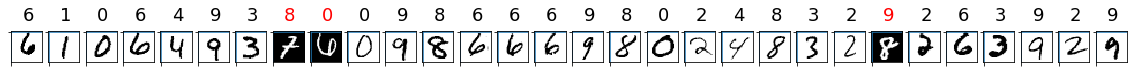

In [62]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))
#plt.figure(figsize=(9, 3))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1

plt.show()

You can also call the model using a REST API. The code below will call the model to identify a number randomly selected from an array.

In [64]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to include the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://186b50b9-8d09-47a6-87fb-e427f351094d.eastus2.azurecontainer.io/score
label: 8
prediction: [8]
